# 分类 Fashion-MNIST 数据集

现在轮到你来构建一个神经网络了。你将使用的是 [Fashion-MNIST 数据集](https://github.com/zalandoresearch/fashion-mnist)，这是 MNIST 数据集的替代品。对于神经网络而言，原始的 MNIST 数据集体量太小，因而你可以轻易达到 97% 以上的准确率。而 Fashion-MNIST 数据集是一组有关衣物的 28x28 灰阶图像。这个数据集比 MNIST 复杂得多，因此你能更好地判断神经网络的性能，它也更加接近你在现实世界中使用的数据集。

<img src='assets/fashion-mnist-sprite.png' width=500px>

在这个 notebook 中，你将构建专属于你的神经网络。在大多数情况下，你可以直接复制粘贴第三部分的代码，但这样一来你很难学到知识。因此我们推荐你自己编写代码来运行程序，这十分重要。不过在完成这个任务时，你也可以随时查阅和参考之前的 notebook。

首先，我们通过 torchvision 来加载数据集。

In [1]:
import torch
from torchvision import datasets, transforms
import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

在这里，我们能看到其中一张图片。

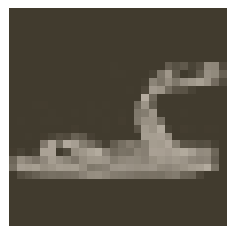

In [2]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

在加载数据之后，我们应该导入一些必要的包了。

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms

import helper

## 构建网络

在这里，你应该定义你的网络。如同 MNIST 数据集一样，这里的每张图片的像素为 28x28，共有 784 个像素点和 10 个类。你至少需要添加一个隐藏层。对于这些层，我们推荐你使用 ReLU 激活函数，并通过前向传播来返回 logits。层的数量和大小都由你来决定。

In [23]:
# DONE: Define your network architecture here
class Network(nn.Module):
    '''
    创建一个名为Network的类 即是神经网络类 其基类是nn.Module
    '''
    def __init__(self):
        super().__init__()
        # 定义各层 输入层为784个节点 输出层为10个节点 这里我自己定3个隐藏层
        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 20)
        self.fc4 = nn.Linear(20, 10)

    
    def forward(self, x):
        '''
        前向传播函数 注意这里是到最终的输出层 还没有经过softmax()函数转化成概率分布！
        '''
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x
        
    def predict(self, x):
        '''
        使用forward()前向传播方法 来得到最终输出层的结果
        将输出层结果经过softmax()函数 得到概率分布 即预测值
        '''
        logits = self.forward(x)
        return F.softmax(logits, dim=1)

# 训练网络

现在，你应该构建你的网络并训练它了。首先，你需要定义[条件](http://pytorch.org/docs/master/nn.html#loss-functions)（比如 `nn.CrossEntropyLoss`）以及[优化器](http://pytorch.org/docs/master/optim.html)（比如 `optim.SGD` 或 `optim.Adam`）。

接着，你需要编写训练代码。请记住，训练传播是一个十分简明的过程：

* 在网络中进行前向传播来获取 logits 
* 使用 logits 来计算损失
* 使用 `loss.backward()` 在网络中进行后向传播来计算梯度
* 使用优化器执行一个学习步来更新权重

通过调整超参数（隐藏单元、学习速率等），你应该可以将训练损失控制在 0.4 以下。

In [24]:
# DONE: Create the network, define the criterion and optimizer
# 创建Network类的实例net
net = Network()
# 创建损失函数 使用交叉熵
criterion = nn.CrossEntropyLoss()
# 创建优化器 这里尝试Adam
optimizer = optim.Adam(net.parameters(), lr=0.001)
net

Network(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=10, bias=True)
)

In [26]:
epochs = 1 # 训练的次数
steps = 0
running_loss = 0
print_every = 20
# 迭代训练
for e in range(epochs):
    for images, labels in iter(trainloader):
        steps += 1
        # 数据处理
        images.resize_(images.size()[0], 784)
        inputs = Variable(images)
        targets = Variable(labels)
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 前向传播 并计算损失
        output = net.forward(inputs)
        loss = criterion(output, targets)
        
        # 反向传播 并更新权重
        loss.backward()
        optimizer.step()
        
        # 这一句也可以写成running_loss += loss.item() 因为这里loss是一个标量张量
        # 而不是简单的数字！要么用索引 要么用items方法
        running_loss += loss.data[0]
        
        # 输出训练损失
        if steps % print_every == 0:
            # 测试准确性
            accuracy = 0
            for ii, (images, labels) in enumerate(testloader):
                
                images = images.resize_(images.size()[0], 784)
                inputs = Variable(images, volatile=True)
                
                predicted = net.predict(inputs).data
                equality = (labels == predicted.max(1)[1])
                accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Test accuracy: {:.4f}".format(accuracy/(ii+1)))
            running_loss = 0
# 这里训练Loss大概在0.4附近 不是特别好 还有待改进！

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch: 1/1 Loss: 0.5687 Test accuracy: 0.7845
Epoch: 1/1 Loss: 0.5251 Test accuracy: 0.7924
Epoch: 1/1 Loss: 0.5627 Test accuracy: 0.8043
Epoch: 1/1 Loss: 0.5018 Test accuracy: 0.8006
Epoch: 1/1 Loss: 0.5251 Test accuracy: 0.8009
Epoch: 1/1 Loss: 0.5398 Test accuracy: 0.8070
Epoch: 1/1 Loss: 0.5016 Test accuracy: 0.7980
Epoch: 1/1 Loss: 0.4880 Test accuracy: 0.8109
Epoch: 1/1 Loss: 0.5434 Test accuracy: 0.8185
Epoch: 1/1 Loss: 0.4959 Test accuracy: 0.8235
Epoch: 1/1 Loss: 0.5033 Test accuracy: 0.8120
Epoch: 1/1 Loss: 0.4244 Test accuracy: 0.8172
Epoch: 1/1 Loss: 0.4764 Test accuracy: 0.8048
Epoch: 1/1 Loss: 0.4830 Test accuracy: 0.8322
Epoch: 1/1 Loss: 0.4575 Test accuracy: 0.8211
Epoch: 1/1 Loss: 0.4383 Test accuracy: 0.8152
Epoch: 1/1 Loss: 0.5068 Test accuracy: 0.8102
Epoch: 1/1 Loss: 0.4449 Test accuracy: 0.8289
Epoch: 1/1 Loss: 0.4469 Test accuracy: 0.8351
Epoch: 1/1 Loss: 0.4237 Test accuracy: 0.8343
Epoch: 1/1 Loss: 0.4315 Test accuracy: 0.8133
Epoch: 1/1 Loss: 0.4571 Test accur

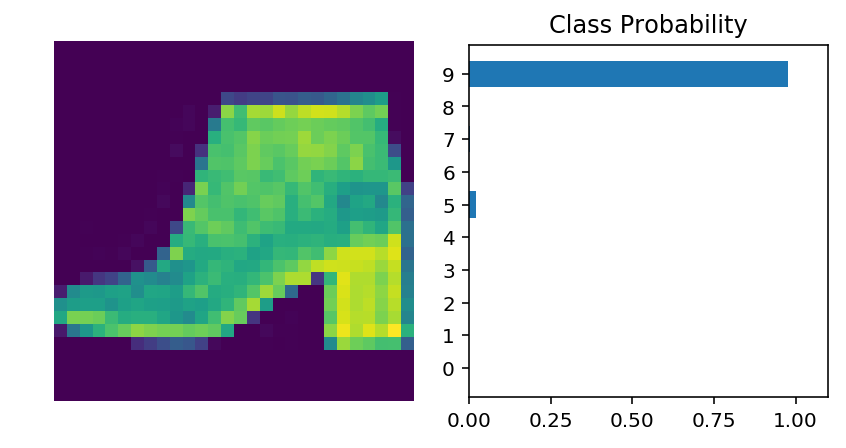

In [27]:
# Test out your network!

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# TODO: Calculate the class probabilities (softmax) for img
ps = net.predict(Variable(img.resize_(1, 784)))

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps)

训练好神经网络之后，你应该希望保存这个网络以便下次加载，而不是重新训练。很明显，每次使用时都重新训练网络并不现实。在实际操作中，你将会在训练网络之后将模型保存，接着重新加载网络以进行训练或是预测。在下一部分，我将为你展示如何保存和加载训练好的模型。